In [2]:
import gym
from envs.gridworld import GridworldEnv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.table import Table
from utils import show_grid
%matplotlib inline

In [3]:
env = GridworldEnv()

When we have the complete model of the MDP, we can use DP to find an optimal policy. 

## Policy Evaluation 

Given a random policy to navigate the gridworld we can evaluate this policy by the following algorithm:

In [4]:
def policy_evaluation(env, policy, theta=0.0001, discount=0.99):
    V = np.zeros(env.nS)
    while True:
        delta = 0
        for s in range(env.nS):
            v = 0
            for a, p_a in enumerate(policy[s]):
                for p, s_, r, done in env.P[s][a]:
                    v += p_a * p * (r + discount * V[s_])

            delta = max(delta, np.abs(v - V[s]))
            V[s] = v

        if delta < theta:
            break
    return V

First we generate a random policy:

In [6]:
random_policy = np.ones((env.nS, env.nA)) / env.nA

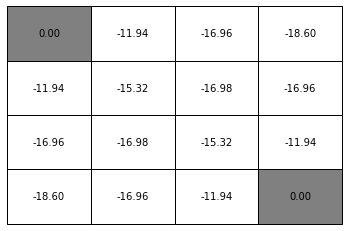

In [7]:
V = policy_evaluation(env, random_policy)
show_grid(V.reshape(4,4))

In [28]:
def policy_iteration(env, policy, discount=0.99):
    
    while True:
        V = policy_evaluation(env, policy)
        
        policy_stable = True
        for s in range(env.nS):
            old_a = np.argmax(policy[s])
        
            action_values = np.zeros(env.nA)
            for a in range(env.nA):
                for p, s_, r, done in env.P[s][a]:
                    action_values[a] += p * (r + discount * V[s_])
            
            new_a = np.argmax(action_values)
            
            policy[s] = np.eye(env.nA)[new_a]

            if old_a != new_a:
                policy_stable = False
            
        if policy_stable:
            return V, policy

In [29]:
V, P = policy_iteration(env, random_policy)